<a href="https://colab.research.google.com/github/camilomarino/DLBioIm/blob/main/Practica_2_Estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2: Introducción a PyTorch

## a) Calculando el gradiente mediante Autograd

En primer lugar, vamos a calcular del gradiente para el perceptrón simple con función de activación sigmoidea que vimos en la teoría. Pero esta vez, en lugar de realizar manualmente el proceso de backpropagation, vamos a usar el módulo `autograd` de PyTorch.

La función $f(x, w)$ a la cual queremos encontrarle el gradiente es:

> $f(\mathbf{x}, \mathbf{w}) = \frac{1}{1 + e^{2-(w_0 x_0 + w_1 x_1 + w_2)}}$

Definimos entonces la función utilizando `torch.tensor` (recordar usar el parámetro `requires_grad = True` para que PyTorch guarde los gradientes) y realizamos la pasada "forward" para los siguientes valores de x y w:

> $\mathbf{x} = (-1, -2)$

> $\mathbf{w} = (2, -3, -3)$



In [1]:
import torch

x = torch.tensor([-1, -2], dtype=torch.float32, requires_grad=True)
w = torch.tensor([2, -3, -3], dtype=torch.float32, requires_grad=True)

x_ = torch.cat((torch.tensor([1]), x)) # agrego un 1 para tener el bias
f = 1 / (1 + torch.exp(2 - (torch.dot(w, x_))))

print(f)

tensor(0.9999, grad_fn=<MulBackward0>)


Ahora, utilizando la función `f.backward()` computamos los gradientes $\frac{\partial f}{ \partial \mathbf{x}}$ y $\frac{\partial f}{ \partial \mathbf{w}}$

In [2]:
f.backward()

In [3]:
print("Gradiente df/dx = " + str(x.grad))
print("Gradiente df/dw = " + str(w.grad))

Gradiente df/dx = tensor([-0.0004, -0.0004])
Gradiente df/dw = tensor([ 0.0001, -0.0001, -0.0002])


## b) Minimizando una función con Gradient Descent

Ahora, vamos a implementar usar el algorítmo de gradiente descendiente (utilizando Autograd para computar el gradiente) para minimizar la función cuadrática $$f(x) = 2x^2 + x + 4$$

Utilizaremos la implementación `torch.optim.SGD` de gradiente descendiente.



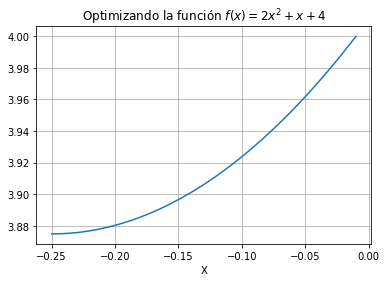

In [25]:
import matplotlib.pyplot as plt

# Definir la variable que será el parámetro a optimizar
x = torch.tensor([0], dtype=torch.float32, requires_grad=True)

# Definir el optimizador, indicando el parámetro a optimizar y el learning rate
optimizer = torch.optim.SGD([x], lr=1e-2)

# Acumuladores que usaremos para guardar los valores sucesivos de x, y
f_values = []
x_values = []

# Loop de optimización
for i in range(1000):

    # Setemos en 0 los gradientes de todos los elementos
    optimizer.zero_grad()

    # Pasada forward: ejecutar la función a minimizar
    f = 2 * x**2 + x + 4

    print(f"iter = {i},\t X = {float(x):.3f},\t f(x) = {float(f):.3f}" )

    # Pasada backward: computar los gradientes
    f.backward()

    # Actualizar los pesos dando un paso de gradiente descendiente
    optimizer.step()

    # Guardar los valores para luego plotearlos
    f_values.append(f.data.item())
    x_values.append(x.data.item())

# Ploteo los valores
fig_pregunta_1, ax = plt.subplots()
ax.set_title(r"Optimizando la función $f(x) = 2 x^2 + x + 4$")
ax.set_xlabel("X")
ax.plot(x_values, f_values)
ax.grid(True)

# c) Implementando un MLP en PyTorch para predicción del procentaje de grasa corporal

Contamos con una base de datos [1] de 252 mediciones del porcentaje de grasa corporal de 252 personas diferentes, el cual puede ser estimado mediante otras características, como la edad, el peso, y mediciones en diferentes partes del cuerpo. A partir de estos datos se pretende desarrollar un sistema que permita predecir dicho porcentaje a partir de las características.

[1]: Olson, R.S., La Cava, W., Orzechowski, P. et al. PMLB: a large benchmark suite for machine learning evaluation and comparison. BioData Mining 10, 36 (2017). https://epistasislab.github.io/pmlb/profile/560_bodyfat.html

Antes de comenzar, vamos a instalar el paquete de Python que contiene la base de datos:

In [5]:
!pip install pmlb

Ahora vamos a generar un histograma de todas las mediciones del porcentaje con todos los datos disponibles:

          Density         Age      Weight      Height        Neck       Chest  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean     1.055574   44.884921  178.924405   70.148810   37.992064  100.824206   
std      0.019031   12.602040   29.389160    3.662856    2.430913    8.430476   
min      0.995000   22.000000  118.500000   29.500000   31.100000   79.300003   
25%      1.041400   35.750000  159.000000   68.250000   36.400002   94.350000   
50%      1.054900   43.000000  176.500000   70.000000   38.000000   99.649998   
75%      1.070400   54.000000  197.000000   72.250000   39.425001  105.375002   
max      1.108900   81.000000  363.149994   77.750000   51.200001  136.199997   

          Abdomen         Hip       Thigh        Knee       Ankle      Biceps  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    92.555952   99.904762   59.405952   38.590476   23.102381   32.273413   
std     10.783077    7.1640

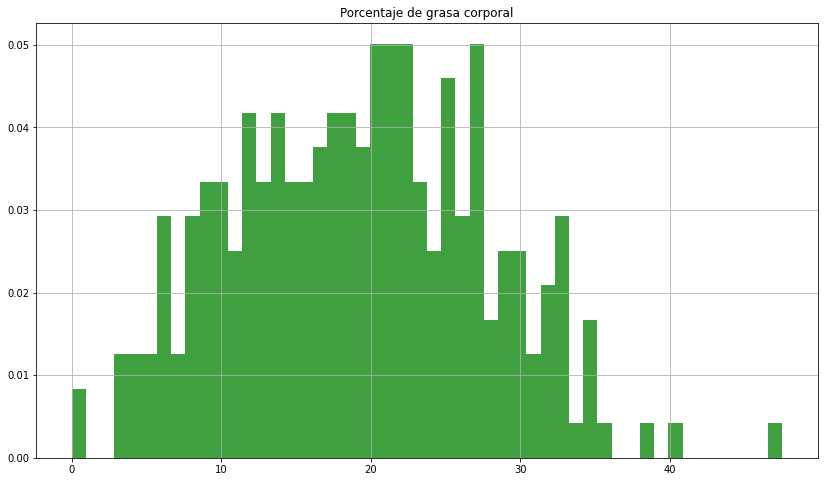

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pmlb import fetch_data

# Importamos el dataset
body_fat = fetch_data("560_bodyfat")
print(body_fat.describe())

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != "target"].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == "target"].to_numpy()

data = data.astype(np.float32)
percentages = percentages.astype(np.float32)

print("Fila de ejemplo:")
print(list(body_fat.columns))
print(data[0, :])

# Dibujo un histograma del porcentaje de grasa corporal usando todos los datos
plt.figure(figsize=(14, 8))
plt.hist(percentages, 50, density=True, facecolor="g", alpha=0.75)
plt.title("Porcentaje de grasa corporal")
plt.grid(True)

Particionamos los datos en entrenamiento y prueba usando la función `sklearn.model_selection.train_test_split`

In [7]:
from sklearn.model_selection import train_test_split

# Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split(
    data, percentages, test_size=0.33, random_state=42
)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((168, 14), (84, 14), (168, 1), (84, 1))

Ahora implementaremos en PyTorch un Perceptrón multicapa que usaremos como regresor del porcentaje de grasa corporal (ejemplo basado en el curso de [RPI](https://rpi.analyticsdojo.com/)).

El perceptrón deberá contar con 3 capas:
- Las dos primeras con 200 neuronas, y deberán usar la función de activación ReLU.
- La última con una única neurona cuya salida sea un valor escalar que corresponda al porcentaje de grasa corporal estimado de la persona, que no deberá utilizar ninguna función de activación.

Algunas clases de PyTorch que resultarán útiles para implementar el modelo, son:
- `torch.nn.Linear`: Implementa una capa totalmente conectada. Es necesario especificarle el número de parámetros de entrada y de salida.
- `torch.nn.functional.relu`: Implementa la función de activación ReLU.

Además, utilizaremos el optimizador `torch.optim.Adam` y la función de pérdida `torch.nn.MSELoss` (error cuadrático medio).






100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 246.46it/s]


MSE medio en training con hidden_size=2: 77.30475
MSE medio en test con hidden_size=2: 54.80799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 246.34it/s]


MSE medio en training con hidden_size=10: 15.548567
MSE medio en test con hidden_size=10: 19.029032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.95it/s]


MSE medio en training con hidden_size=200: 0.6588854
MSE medio en test con hidden_size=200: 30.448275


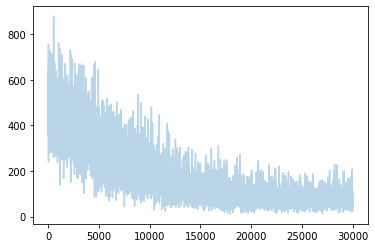

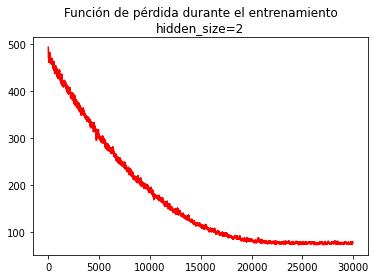

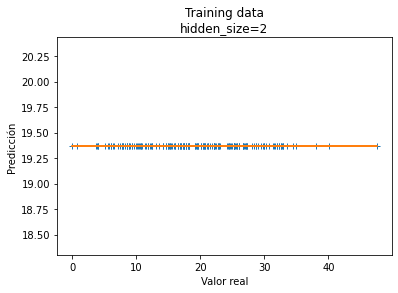

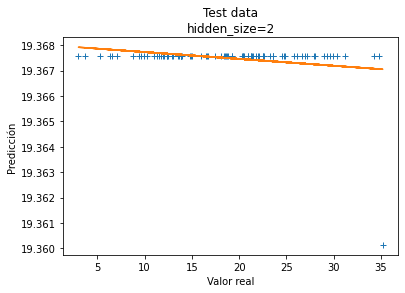

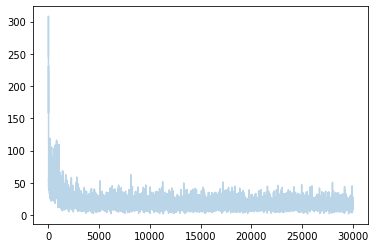

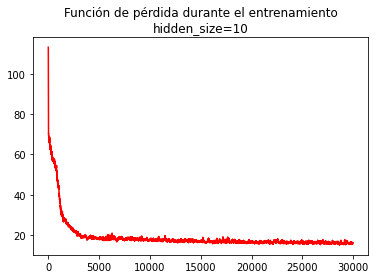

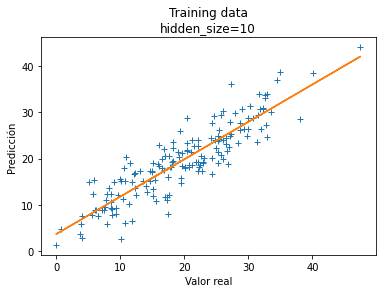

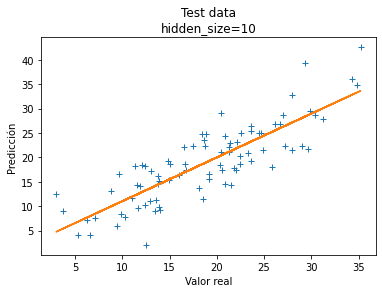

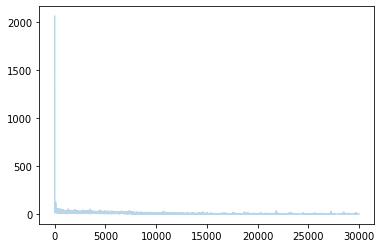

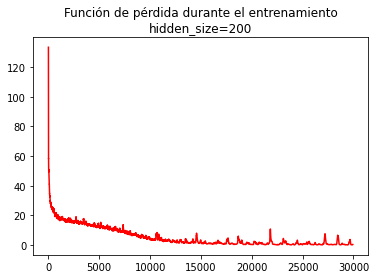

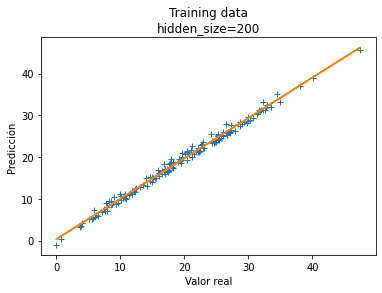

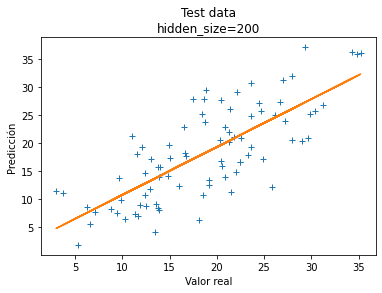

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


class Net(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return x


def trainer(
    net: nn.Module,
    learning_rate=1e-3,
    batch_size=32,
    verbose: bool = False,
) -> list:
    # Construimos el optimizador, y le indicamos que los parámetros a optimizar
    # son los del modelo definido: net.parameters()

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Definimos también la función de pérdida a utilizar
    criterion = nn.MSELoss()

    # Creamos el objeto dataset que empaqueta los array de numpy para que puedan
    # ser leidos por PyTorch
    dataset = TensorDataset(
        torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone()
    )

    # Creamos un loader iterable indicandole que debe leer los datos a partir de
    # del dataset creado en el paso anterior. Este objeto puede ser iterado
    # y nos devuelve de a un batch (x, y).
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    # Número de épocas
    num_epochs = 5000

    # Lista en la que iremos guardando el valor de la función de pérdida en cada
    # etapa de entrenamiento
    loss_list = []

    # Bucle de entrenamiento
    for i in tqdm(range(num_epochs)):
        total_loss = 0.0
        for x, y in loader:
            # Seteo en cero los gradientes de los parámetros a optimizar
            optimizer.zero_grad()

            output = net(x)
            # Realizo la pasada forward por la red
            loss = criterion(output, y)

            # # Realizo la pasada backward por la red
            loss.backward()

            # # Actualizo los pesos de la red con el optimizador
            optimizer.step()

            # Me guardo el valor actual de la función de pérdida para luego graficarlo
            loss_list.append(loss.data.item())

            # Acumulo la loss del minibatch
            total_loss += loss.item() * y.size(0)

        # Normalizo la loss total
        total_loss /= len(loader.dataset)

        # Muestro el valor de la función de pérdida cada 100 iteraciones
        if i > 0 and i % 100 == 0 and verbose:
            print("Epoch %d, loss = %g" % (i, total_loss))

    return loss_list


# Definimos un método para mostrar las predicciones como un scatter plot
# y graficamos la recta de regresión para esos datos.
def plotScatter(x_data, y_data, title, fit_line=True):
    plt.figure()
    plt.plot(x_data, y_data, "+")
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(title)

    if fit_line:
        X, Y = x_data.reshape(-1, 1), y_data.reshape(-1, 1)
        plt.plot(X, LinearRegression().fit(X, Y).predict(X))


nets = {
    2: Net(14, 2, 1),
    10: Net(14, 10, 1),
    200: Net(14, 200, 1),
}

for hidden_size, net in nets.items():
    loss_list = trainer(net)
    # Muestro la lista que contiene los valores de la función de pérdida
    # y una versión suavizada (rojo) para observar la tendencia
    plt.figure()
    loss_np_array = np.array(loss_list)
    plt.plot(loss_np_array, alpha=0.3)
    N = 60
    running_avg_loss = np.convolve(loss_np_array, np.ones((N,)) / N, mode="valid")
    plt.figure()
    plt.plot(running_avg_loss, color="red")
    plt.title(
        "Función de pérdida durante el entrenamiento\n" f"hidden_size={hidden_size}"
    )

    # Dibujamos el ground truth vs las predicciones en los datos de entrenamiento
    py = net(torch.FloatTensor(X_train))
    y_pred_train = py.cpu().detach().numpy()
    plotScatter(y_train, y_pred_train, "Training data\n" f"hidden_size={hidden_size}")

    # Dibujamos el ground truth vs las predicciones en los datos de test
    py = net(torch.FloatTensor(X_test))
    y_pred_test = py.cpu().detach().numpy()
    plotScatter(y_test, y_pred_test, "Test data\n" f"hidden_size={hidden_size}")

    print(
        f"MSE medio en training con hidden_size={hidden_size}: "
        + str(((y_train - y_pred_train) ** 2).mean())
    )
    print(
        f"MSE medio en test con hidden_size={hidden_size}: "
        + str(((y_test - y_pred_test) ** 2).mean())
    )

# Entregable 
1. Encontrar el mínimo de la función *f* definida en el apartado b). Para ello, deberán encontrar primero la derivada *f'(x)* de forma analítica, y utilizarla para computar el mínimo de la función. Posteriormente, deberán corrobarar que el valor coincida con el que obtuvieron optimizando la función con gradiente descendiente. 

2. Compara el rendimiento de 3 perceptrones multicapa que varíen en la cantidad de neuronas en sus capas intermedia. Probar colocando 2, 10 y 200 neuronas en dichas capas, al entrenar los perceptrones durante 5000 épocas. Mostrar los resultados utilizando:

* los gráficos de dispersión con la recta de regresión
* el error medio en los datos de entrenamiento y test

  Analizar la relación entre dichos resultados y la cantidad de neuronas que posee el perceptrón.
 

# Respuestas

1. La función a optimizar es: 
$$f(x) = 2x^2 + x + 4$$
La derivada es:
$$f'(x) = 4x + 1$$
El valor $x$ que anula la derivada $-\frac{1}{4}$. Por ser $f(x)$ una parábola convexa, entonces el óptimo es $x_{opt} = - \frac{1}{4}$. Este valor coincide con el que se obtuvo con el autograd de pytorch, en particular se llego a $0.25$ luego de aproximadamente 150 iteraciones con el optimizador SGD con un leraning rate de $10^{-2}$ .
En la figura de la celda siguiente se observa la evolución hacia el resultado esperado.

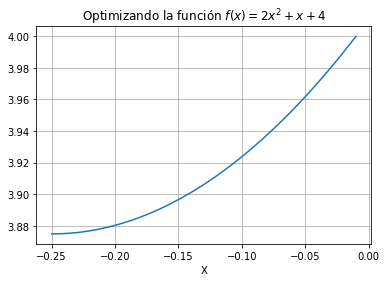

In [26]:
fig_pregunta_1